# Проект: Прогнозирование покупок клиентов интернет-магазина через 90 дней

## Описание проекта

Интернет-магазин собирает данные о покупках клиентов и рекламных коммуникациях. Основной задачей является выделение пользователей, которые готовы совершить покупку в ближайшее время, чтобы оптимизировать маркетинговые кампании и повысить конверсию от рассылок.

**Цель проекта**: 
- Построить модель, которая будет предсказывать вероятность совершения покупки клиентом в течение 90 дней после получения рекламного сообщения.

**Основные задачи**:
1. Изучить предоставленные данные.
2. Провести инжиниринг признаков на основе истории покупок, данных о рекламных кампаниях и активности пользователей.
3. Построить модель для бинарной классификации, которая будет прогнозировать вероятность покупки.
4. Оптимизировать модель, добиваясь максимальной метрики **ROC-AUC**.
5. Провести финальное тестирование и представить результаты.

## Данные

Проект использует несколько источников данных:

### 1. **Apparel Purchases Dataset** (История покупок)
- **Описание**: Данные о покупках клиентов, включая количество товаров, цены и категории товаров.
- **Основные колонки**:
  - `client_id`: Уникальный идентификатор клиента.
  - `quantity`: Количество товаров в заказе.
  - `price`: Цена товара.
  - `category_ids`: Вложенные категории товара.
  - `date`: Дата покупки.
  - `message_id`: Идентификатор рекламного сообщения.

### 2. **Apparel Target Binary Dataset** (Целевые данные)
- **Описание**: Бинарные метки, указывающие на то, совершил ли клиент покупку в течение 90 дней.
- **Основные колонки**:
  - `client_id`: Уникальный идентификатор клиента.
  - `target`: 1 — если клиент совершил покупку, 0 — если не совершил.

### 3. **Full Campaign Daily Event Dataset** (Ежедневные события рекламных кампаний)
- **Описание**: Данные о взаимодействиях клиентов с рекламными кампаниями по дням.
- **Основные колонки**:
  - `bulk_campaign_id`: Идентификатор рекламной кампании.
  - `date`: Дата события.
  - `count_*`: Количество событий (клики, открытия, покупки и т.д.).
  - `nunique_*`: Количество уникальных клиентов для каждого события.

### 4. **Full Campaign Daily Event Channel Dataset** (Ежедневные события с разбивкой по каналам)
- **Описание**: Похожие данные на предыдущий датасет, но с детализацией по каналам (email, push-уведомления и т.д.).
- **Основные колонки**:
  - `bulk_campaign_id`: Идентификатор рекламной кампании.
  - `date`: Дата события.
  - `count_*_channel_*`: Количество событий для каждого канала.
  - `nunique_*_channel_*`: Количество уникальных клиентов для каждого события и канала.

### 5. **Apparel Messages Dataset** (История рекламных коммуникаций)
- **Описание**: История рекламных сообщений, отправленных клиентам.
- **Основные колонки**:
  - `bulk_campaign_id`: Идентификатор рекламной кампании.
  - `client_id`: Уникальный идентификатор клиента.
  - `message_id`: Идентификатор сообщения.
  - `event`: Тип события (например, открытие или клик).
  - `channel`: Канал рассылки (email, push и т.д.).
  - `date`: Дата события.
  - `created_at`: Время создания сообщения.

In [99]:
import pandas as pd
import ast
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
pd.option_context('mode.use_inf_as_na', True)

In [4]:
def extract_unique_categories(category_list_str):
    # Преобразуем строку списка в настоящий список
    category_list = ast.literal_eval(category_list_str)
    # Возвращаем множество уникальных категорий
    return set(category_list)

In [101]:
def plot_numerical_feature(data, feature):
    """
    Строит гистограмму и коробчатую диаграмму для числового признака.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Гист
    sns.histplot(data[feature], kde=True, ax=axs[0], color='skyblue')
    axs[0].set_title(f'Гистограмма {feature}')

    # Бокс
    sns.boxplot(x=data[feature], ax=axs[1], color='lightgreen')
    axs[1].set_title(f'Коробчатая диаграмма {feature}')

    plt.tight_layout()
    plt.show()

In [103]:
def plot_categorical_feature(data, feature):
    """
    Строит столбчатую и круговую диаграммы для категориального признака.
    """
    counts = data[feature].value_counts()

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Бар
    sns.barplot(x=counts.index, y=counts.values, ax=axs[0], palette='pastel')
    axs[0].set_title(f'Столбчатая диаграмма {feature}')
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)

    # Пай
    axs[1].pie(counts.values, labels=counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
    axs[1].set_title(f'Круговая диаграмма {feature}')

    plt.tight_layout()
    plt.show()


In [5]:
data = pd.read_csv('./datasets/apparel-messages.csv')

In [6]:
data_c = data.copy(deep=True)

In [7]:
data['bulk_campaign_id'].unique().size

2709

In [8]:
data['client_id'].unique().size

53329

Всего 2709 компаний И 53329 клиентов 

In [9]:
data.describe()

,bulk_campaign_id,client_id
count,1.273980e+07,1.273980e+07
mean,1.160459e+04,1.515916e+18
std,3.259211e+03,1.329704e+08
min,5.480000e+02,1.515916e+18
25%,8.746000e+03,1.515916e+18
50%,1.351600e+04,1.515916e+18
75%,1.415800e+04,1.515916e+18
max,1.465700e+04,1.515916e+18


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [11]:
data.head(20)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


In [12]:
data_1 = pd.read_csv('./datasets/apparel-purchases.csv')

In [13]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [14]:
data_1.describe()

,client_id,quantity,price
count,2.022080e+05,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516
std,1.459458e+08,0.184384,1342.252664
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,352.000000
50%,1.515916e+18,1.000000,987.000000
75%,1.515916e+18,1.000000,1699.000000
max,1.515916e+18,30.000000,85499.000000


In [15]:
data_1.head(20)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


In [16]:
data_2 = pd.read_csv('./datasets/full_campaign_daily_event.csv')

In [17]:
data_2.head(30)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,2022-05-19,764,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
6,2022-05-19,766,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
7,2022-05-19,783,1,0,0,8,0,0,0,0,...,6,0,0,0,0,0,0,0,0,0
8,2022-05-19,817,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
9,2022-05-19,833,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [18]:
data_2.describe()

,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
count,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,...,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,90.982971,0.932655,78.473434,3.771091e+03,0.577927,1.163414e+04,27.807312,0.140518,6.362679,...,3.683000e+03,0.465103,1.153716e+04,27.573799,0.134125,5.960602,0.810364,0.809799,0.000008,0.000008
std,4877.369306,1275.503564,30.198326,1961.317826,6.516067e+04,9.107040,1.757095e+05,736.944714,2.072777,79.172069,...,6.258647e+04,7.126368,1.727005e+05,734.050700,1.976439,73.284148,183.298579,183.298245,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,2.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,...,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,128453.000000,5160.000000,287404.000000,5.076151e+06,1077.000000,1.154351e+07,76284.000000,189.000000,9089.000000,...,2.922440e+06,779.000000,7.094600e+06,76281.000000,177.000000,8299.000000,63920.000000,63920.000000,1.000000,1.000000


In [19]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

In [20]:
data_3 = pd.read_csv('./datasets/full_campaign_daily_event_channel.csv')

In [21]:
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

In [22]:
data_3.describe()

,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
count,131072.000000,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,...,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,41.582169,49.400803,4.237060e+02,3.347385e+03,0.357483,0.220444,24.474823,0.140518,6.362679,...,4.189581e+03,18.535683,0.809799,4.186898e+03,3.332489,3.311653,0.932655,0.921326,0.000008,0.000008
std,4877.369306,745.484035,1036.952898,9.753384e+03,6.444859e+04,8.287483,3.796500,727.069387,2.072777,79.172069,...,1.073198e+05,1349.473695,183.298245,1.072618e+05,120.916269,120.094858,30.198326,29.715170,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,59365.000000,128453.000000,2.597015e+06,5.076151e+06,1077.000000,431.000000,76284.000000,189.000000,9089.000000,...,7.094600e+06,287341.000000,63920.000000,7.094600e+06,21831.000000,21389.000000,5160.000000,5043.000000,1.000000,1.000000


In [23]:
data_3.head(20)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2022-05-19,764,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2022-05-19,766,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2022-05-19,783,1,0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2022-05-19,817,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2022-05-19,833,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
targets = pd.read_csv('./datasets/apparel-target_binary.csv')

In [25]:
targets

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
...,...,...
49844,1515915626010261344,0
49845,1515915626010266132,0
49846,1515915626010439406,0
49847,1515915626010443527,0


In [26]:
data_list = [data,data_1,data_2,data_3,targets]

Я просмотрел данные и увидел одну особенность, есть клиенты, которым не предшествовало никакое рекланмое действие. Это очень ценная инфа для дальнейшего анализа, но я не смогу ее реализовать здесь и сейчас. Вместо этог оя предлагаю сделать так:  просто заполню записи -1 или no_info, где никакая маркетингавая активность не предшествовала, но в идеале я бы передал это аналитикам(или стукнул бы дата инженерам за такие данные)

Объединим всё в один дф

In [27]:
# Шаг 1: Преобразуем даты в тип datetime
data_1['date'] = pd.to_datetime(data_1['date'])
data['created_at'] = pd.to_datetime(data['created_at'])

In [28]:
merged_data = pd.merge(data_1, targets, on='client_id', how='left')

In [29]:
merged_data = pd.merge(merged_data, data, on=['client_id', 'message_id'], how='left', suffixes=('_purchase', '_message'))

In [30]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862248 entries, 0 to 862247
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         862248 non-null  int64         
 1   quantity          862248 non-null  int64         
 2   price             862248 non-null  float64       
 3   category_ids      862248 non-null  object        
 4   date_purchase     862248 non-null  datetime64[ns]
 5   message_id        862248 non-null  object        
 6   target            862248 non-null  int64         
 7   bulk_campaign_id  805820 non-null  float64       
 8   event             805820 non-null  object        
 9   channel           805820 non-null  object        
 10  date_message      805820 non-null  object        
 11  created_at        805820 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(3), object(5)
memory usage: 78.9+ MB


In [31]:
merged_data['date_purchase'] = pd.to_datetime(merged_data['date_purchase'])
merged_data['date_message'] = pd.to_datetime(merged_data['date_message']).dt.date

In [32]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862248 entries, 0 to 862247
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         862248 non-null  int64         
 1   quantity          862248 non-null  int64         
 2   price             862248 non-null  float64       
 3   category_ids      862248 non-null  object        
 4   date_purchase     862248 non-null  datetime64[ns]
 5   message_id        862248 non-null  object        
 6   target            862248 non-null  int64         
 7   bulk_campaign_id  805820 non-null  float64       
 8   event             805820 non-null  object        
 9   channel           805820 non-null  object        
 10  date_message      805820 non-null  object        
 11  created_at        805820 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(3), object(5)
memory usage: 78.9+ MB


In [33]:
# Оставляем только нужные столбцы
# Выбираем дату из покупок (date_purchase), а дату из рассылок (created_at или date_message) удаляем
merged_data.drop(columns=['date_message'], inplace=True)  # Удаляем дублирующую дату

In [34]:
merged_data['event'].fillna('no_information', inplace=True)
merged_data['channel'].fillna('no_information', inplace=True)
merged_data['bulk_campaign_id'].fillna(-1, inplace=True)

C:\Users\godcl\AppData\Local\Temp\ipykernel_3516\1644192985.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['event'].fillna('no_information', inplace=True)
C:\Users\godcl\AppData\Local\Temp\ipykernel_3516\1644192985.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [35]:
merged_data['has_interaction'] = merged_data['created_at'].apply(lambda x: 0 if pd.isna(x) else 1)

In [36]:
merged_data['created_at'].fillna(pd.to_datetime('1970-01-01'), inplace=True)

C:\Users\godcl\AppData\Local\Temp\ipykernel_3516\4001091804.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['created_at'].fillna(pd.to_datetime('1970-01-01'), inplace=True)


In [37]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862248 entries, 0 to 862247
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         862248 non-null  int64         
 1   quantity          862248 non-null  int64         
 2   price             862248 non-null  float64       
 3   category_ids      862248 non-null  object        
 4   date_purchase     862248 non-null  datetime64[ns]
 5   message_id        862248 non-null  object        
 6   target            862248 non-null  int64         
 7   bulk_campaign_id  862248 non-null  float64       
 8   event             862248 non-null  object        
 9   channel           862248 non-null  object        
 10  created_at        862248 non-null  datetime64[ns]
 11  has_interaction   862248 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(4), object(4)
memory usage: 78.9+ MB


In [38]:
merged_data

,client_id,quantity,price,category_ids,date_purchase,message_id,target,bulk_campaign_id,event,channel,created_at,has_interaction
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,-1.0,no_information,no_information,1970-01-01 00:00:00,0
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,-1.0,no_information,no_information,1970-01-01 00:00:00,0
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,0,-1.0,no_information,no_information,1970-01-01 00:00:00,0
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,0,-1.0,no_information,no_information,1970-01-01 00:00:00,0
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,0,-1.0,no_information,no_information,1970-01-01 00:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
862243,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,0,14648.0,click,mobile_push,2024-02-15 16:23:39,1
862244,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,0,-1.0,no_information,no_information,1970-01-01 00:00:00,0
862245,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,0,-1.0,no_information,no_information,1970-01-01 00:00:00,0
862246,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490,0,-1.0,no_information,no_information,1970-01-01 00:00:00,0


In [39]:
# Преобразование столбца date в datetime для обоих датафреймов
data_2['date'] = pd.to_datetime(data_2['date'])
data_3['date'] = pd.to_datetime(data_3['date'])

In [40]:
# Агрегация данных по рекламной кампании в data_2 (full_campaign_daily_event)
campaign_aggregation_2 = data_2.groupby('bulk_campaign_id').agg(
    total_clicks=('count_click', 'sum'),
    total_purchases=('count_purchase', 'sum'),
    total_opens=('count_open', 'sum')
).reset_index()

# Агрегация данных по рекламной кампании в data_3 (full_campaign_daily_event_channel)
campaign_aggregation_3 = data_3.groupby('bulk_campaign_id').agg(
    total_clicks_email=('count_click_email', 'sum'),
    total_clicks_push=('count_click_mobile_push', 'sum'),
    total_opens_email=('count_open_email', 'sum'),
    total_opens_push=('count_open_mobile_push', 'sum'),
    total_purchases_email=('count_purchase_email', 'sum'),
    total_purchases_push=('count_purchase_mobile_push', 'sum')
).reset_index()

In [41]:
campaign_aggregation_3

,bulk_campaign_id,total_clicks_email,total_clicks_push,total_opens_email,total_opens_push,total_purchases_email,total_purchases_push
0,548,0,0,5,0,0,0
1,563,37,0,49,0,1,0
2,577,0,0,133,0,0,0
3,585,9,0,51,0,0,0
4,594,2,0,44,0,0,0
...,...,...,...,...,...,...,...
3176,15146,0,18322,0,435347,0,21
3177,15147,0,11146,0,367678,0,31
3178,15148,12829,0,133038,0,15,0
3179,15149,0,18,0,34,0,0


In [42]:
campaign_aggregation_2

,bulk_campaign_id,total_clicks,total_purchases,total_opens
0,548,0,0,5
1,563,37,1,49
2,577,0,0,133
3,585,9,0,51
4,594,2,0,44
...,...,...,...,...
3176,15146,18322,21,435347
3177,15147,11146,31,367678
3178,15148,12829,15,133038
3179,15149,18,0,34


In [43]:
# Сколько записей с корректными значениями bulk_campaign_id
valid_campaign_ids = merged_data[merged_data['bulk_campaign_id'] != -1]
print(f'Количество записей с реальными bulk_campaign_id: {len(valid_campaign_ids)}')

Количество записей с реальными bulk_campaign_id: 805820


In [44]:
# Соединение основной таблицы с данными из data_2
merged_data = pd.merge(merged_data, campaign_aggregation_2, on='bulk_campaign_id', how='left')

# Соединение основной таблицы с данными из data_3
merged_data = pd.merge(merged_data, campaign_aggregation_3, on='bulk_campaign_id', how='left')


In [259]:
aggregated_columns = ['total_clicks', 'total_purchases', 'total_opens', 
                      'total_clicks_email', 'total_clicks_push', 
                      'total_opens_email', 'total_opens_push', 
                      'total_purchases_email', 'total_purchases_push']

merged_data[aggregated_columns] = merged_data[aggregated_columns].fillna(0)

Поскольку порядок категорий может меняться, но нумерация категорий сквозная, логично рассматривать категории как множество уникальных идентификаторов для каждой покупки.

In [45]:
merged_data['unique_categories'] = merged_data['category_ids'].apply(extract_unique_categories)

In [46]:
# Собираем множество всех уникальных категорий
all_categories = set()
merged_data['unique_categories'].apply(lambda x: all_categories.update(x))

0         None
1         None
2         None
3         None
4         None
          ... 
862243    None
862244    None
862245    None
862246    None
862247    None
Name: unique_categories, Length: 862248, dtype: object

In [65]:
# Преобразуем каждую категорию в строку и исключаем None
sentences = merged_data['unique_categories'].apply(lambda x: [str(category) for category in x if category is not None]).tolist()

Используем модель Word2Vec для обучения эмбеддингов категорий

In [66]:
# Обучаем модель эмбеддингов
w2v_model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, workers=4)

In [68]:
category_embeddings = {category: w2v_model.wv[category] for category in w2v_model.wv.index_to_key}

In [72]:
def aggregate_embeddings(categories_set):
    vectors = [category_embeddings[category] for category in categories_set if category in category_embeddings]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

merged_data['category_embedding'] = merged_data['unique_categories'].apply(aggregate_embeddings)

In [73]:
embedding_size = w2v_model.vector_size
embedding_cols = [f'category_emb_{i}' for i in range(embedding_size)]
merged_data[embedding_cols] = pd.DataFrame(merged_data['category_embedding'].tolist(), index=merged_data.index)

In [74]:
# Агрегация покупок
purchase_agg = merged_data.groupby('client_id').agg({
    'quantity': 'sum',
    'price': ['sum', 'mean', 'max'],
    'date_purchase': 'max',
})

purchase_agg.columns = ['total_quantity', 'total_spent', 'avg_price', 'max_price', 'last_purchase_date']

# Агрегация взаимодействий
interaction_agg = merged_data.groupby('client_id').agg({
    'has_interaction': 'max',
    'event': lambda x: x.mode()[0] if not x.mode().empty else 'no_information',
    'channel': lambda x: x.mode()[0] if not x.mode().empty else 'no_information',
    'total_clicks': 'sum',
    'total_purchases': 'sum',
    'total_opens': 'sum'
})

# Агрегация эмбеддингов на уровне клиента
client_embedding_agg = merged_data.groupby('client_id')[embedding_cols].mean()

In [80]:
final_data = purchase_agg.join(interaction_agg, on='client_id', how='left')
final_data = final_data.join(client_embedding_agg, on='client_id', how='left')
final_data = final_data.reset_index()

In [206]:
#Дней с последней покупки

In [81]:
final_data['last_purchase_date'] = pd.to_datetime(final_data['last_purchase_date'])
final_data['days_since_last_purchase'] = (pd.to_datetime('2024-02-16') - final_data['last_purchase_date']).dt.days

In [82]:
final_data = pd.merge(final_data, targets, on='client_id', how='left')

# EDA 

In [96]:
for col in final_data.columns:
    miss = final_data[col].isna().sum()
    if miss>0:
        print(f"Количество пропущенных значений в столбце {col}:")
        print(miss)

Пропусков нет

In [97]:
duplicate_rows = final_data[final_data.duplicated()]
print(f"Количество явных дубликатов: {duplicate_rows.shape[0]}")

Количество явных дубликатов: 0


In [98]:
# Приведение строковых столбцов к единому формату
final_data['event'] = final_data['event'].str.lower().str.strip()
final_data['channel'] = final_data['channel'].str.lower().str.strip()

# Проверка уникальных значений
print("Уникальные значения в 'event':", final_data['event'].unique())
print("Уникальные значения в 'channel':", final_data['channel'].unique())

Уникальные значения в 'event': ['purchase' 'click' 'no_information' 'open' 'send' 'complain'
 'unsubscribe' 'hard_bounce']
Уникальные значения в 'channel': ['email' 'no_information' 'mobile_push']


# Визуализация признаков

In [115]:
# Получение списка всех столбцов эмбеддингов
embedding_cols = [col for col in final_data.columns if col.startswith('category_emb_')]

# Выделение числовых признаков
numerical_cols = final_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in embedding_cols and col != 'client_id'and col !='total_purchases' and col!='has_interaction'and col!='target']

In [116]:
categorical_cols = ['event', 'channel','total_purchases','has_interaction','target']

Визуализация признака: total_quantity


c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


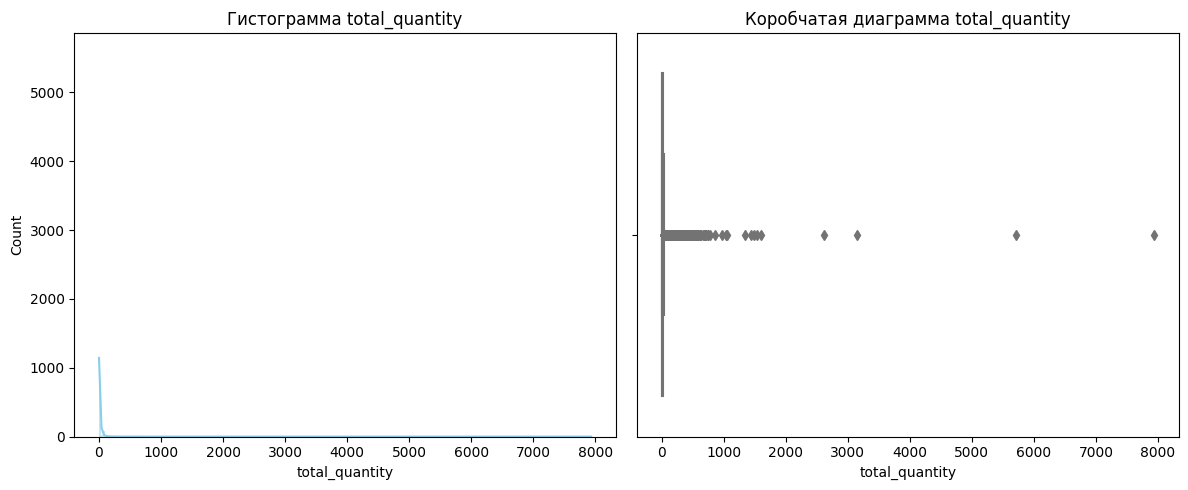

Визуализация признака: total_spent


c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


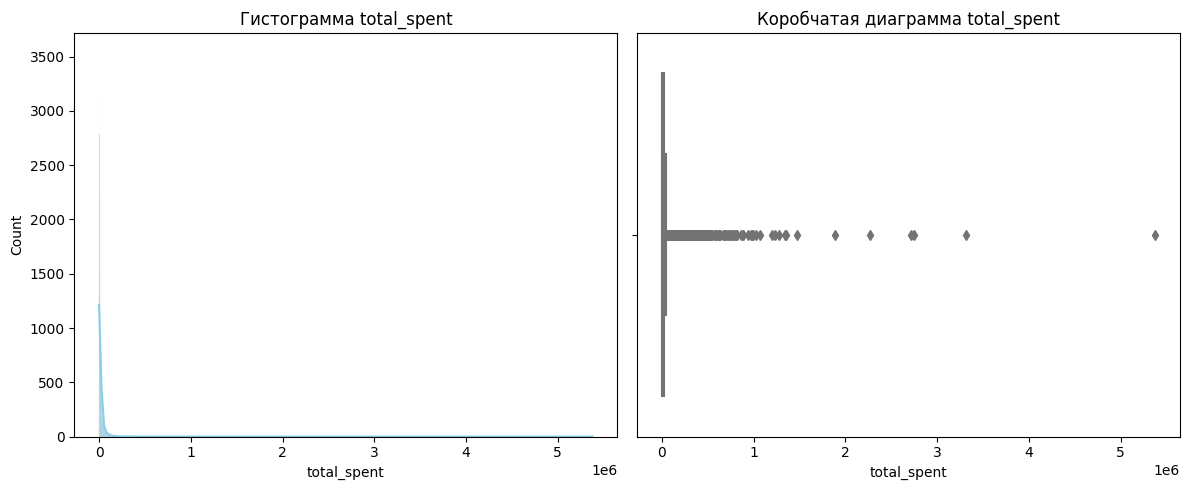

Визуализация признака: avg_price


c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


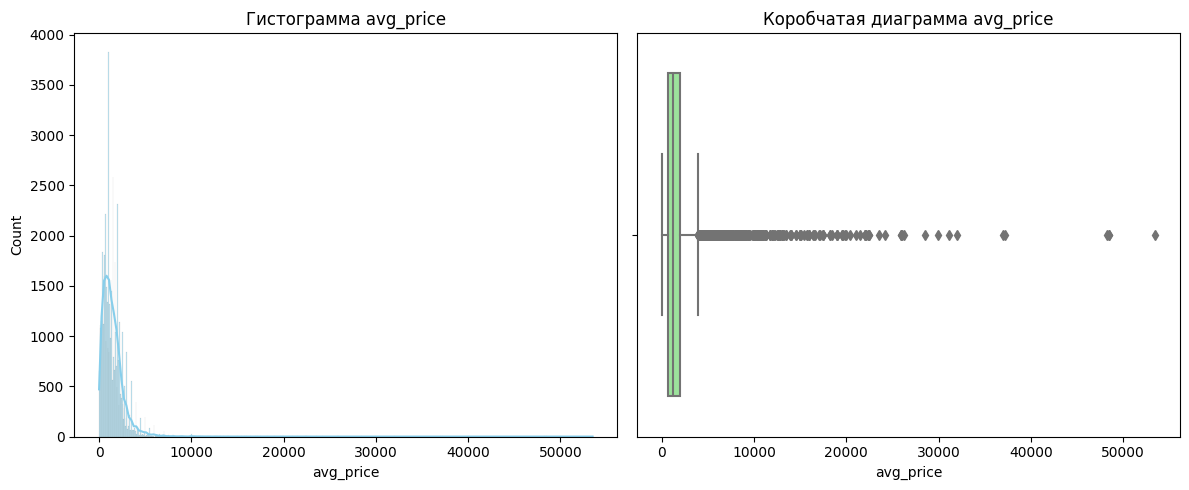

Визуализация признака: max_price


c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


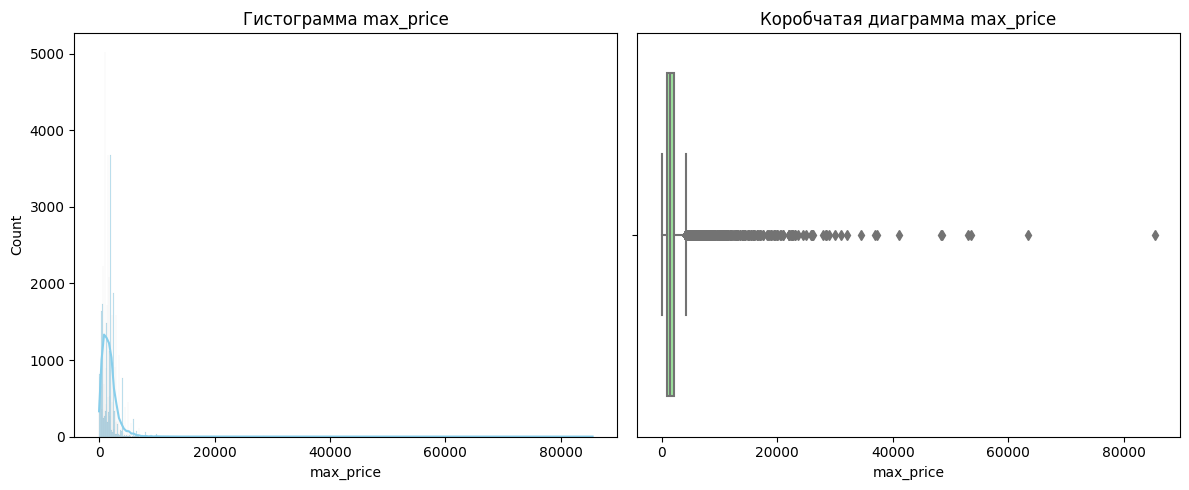

Визуализация признака: total_clicks


c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


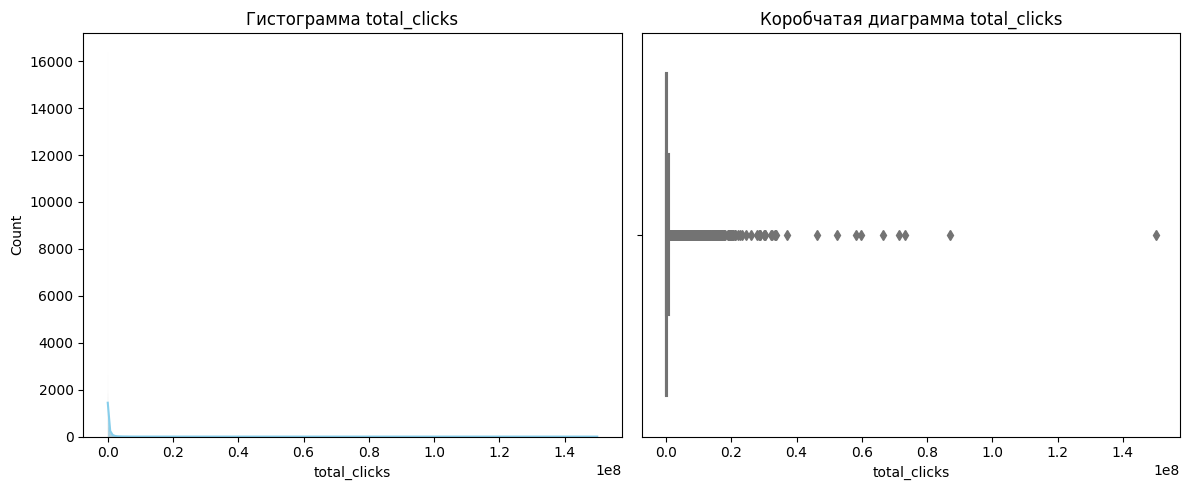

Визуализация признака: total_opens


c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


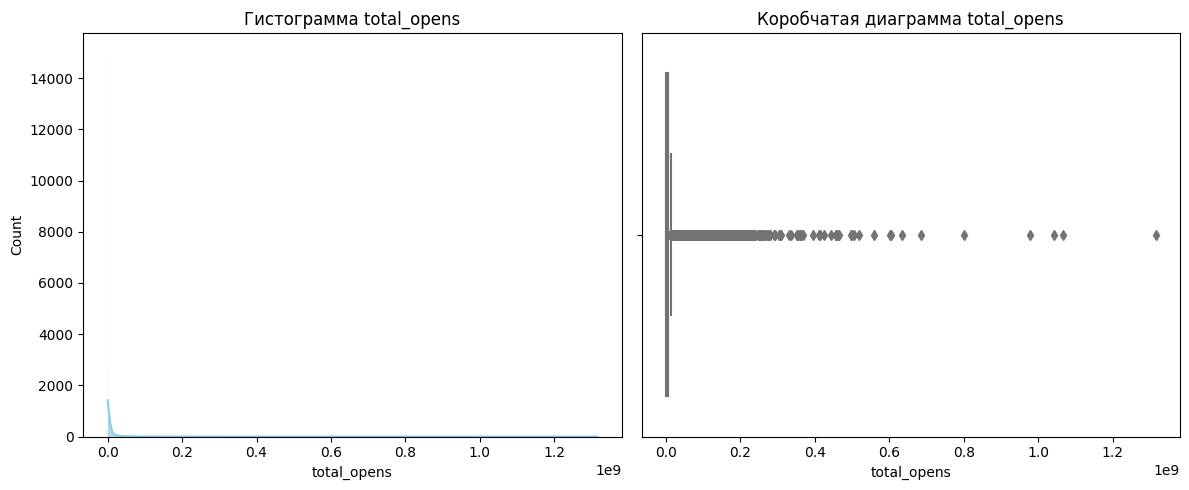

Визуализация признака: days_since_last_purchase


c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


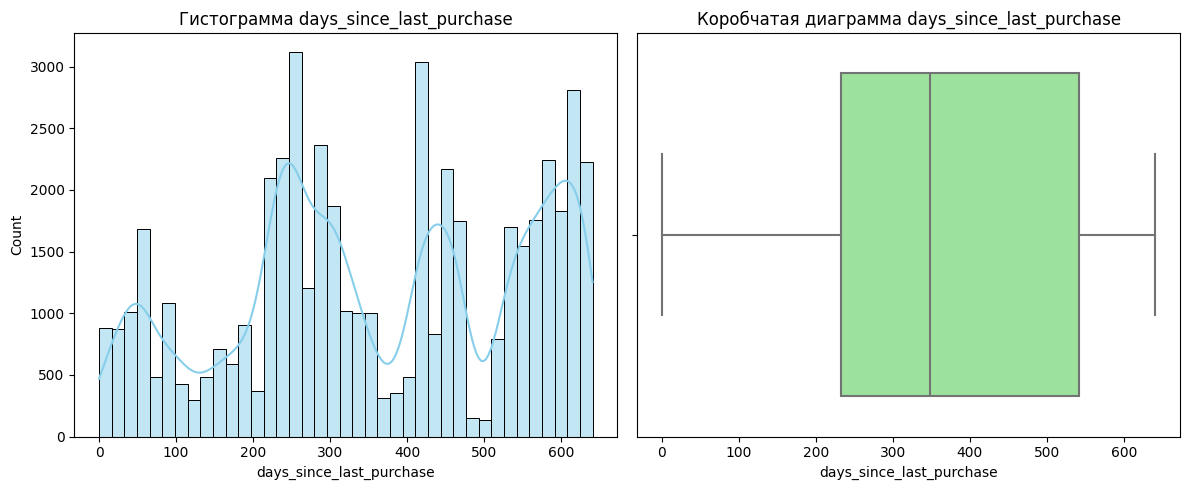

In [117]:
for feature in numerical_cols:
    print(f"Визуализация признака: {feature}")
    plot_numerical_feature(final_data, feature)


In [124]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 64 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49849 non-null  int64         
 1   total_quantity            49849 non-null  int64         
 2   total_spent               49849 non-null  float64       
 3   avg_price                 49849 non-null  float64       
 4   max_price                 49849 non-null  float64       
 5   last_purchase_date        49849 non-null  datetime64[ns]
 6   has_interaction           49849 non-null  int64         
 7   event                     49849 non-null  object        
 8   channel                   49849 non-null  object        
 9   total_clicks              49849 non-null  float64       
 10  total_purchases           49849 non-null  float64       
 11  total_opens               49849 non-null  float64       
 12  category_emb_0    

Визуализация признака: event


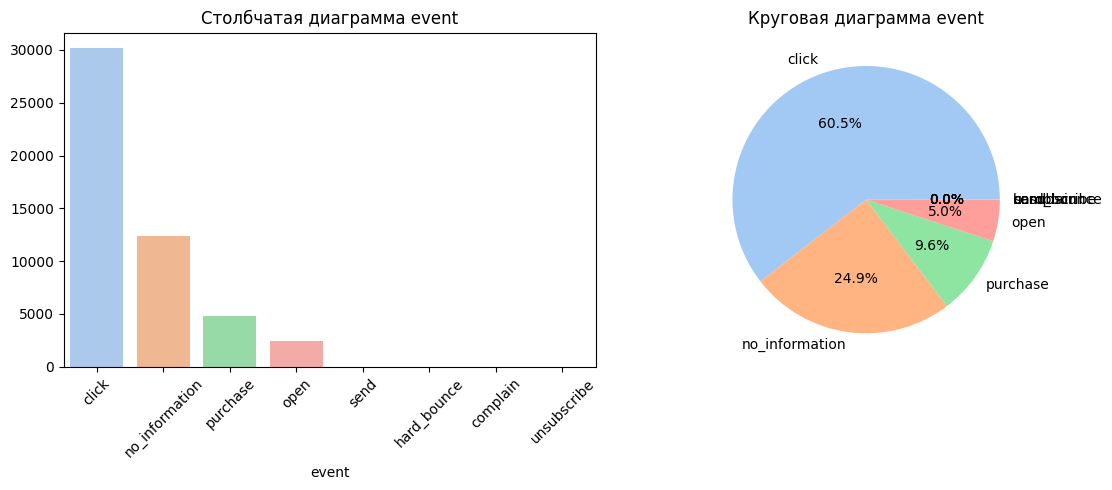

Визуализация признака: channel


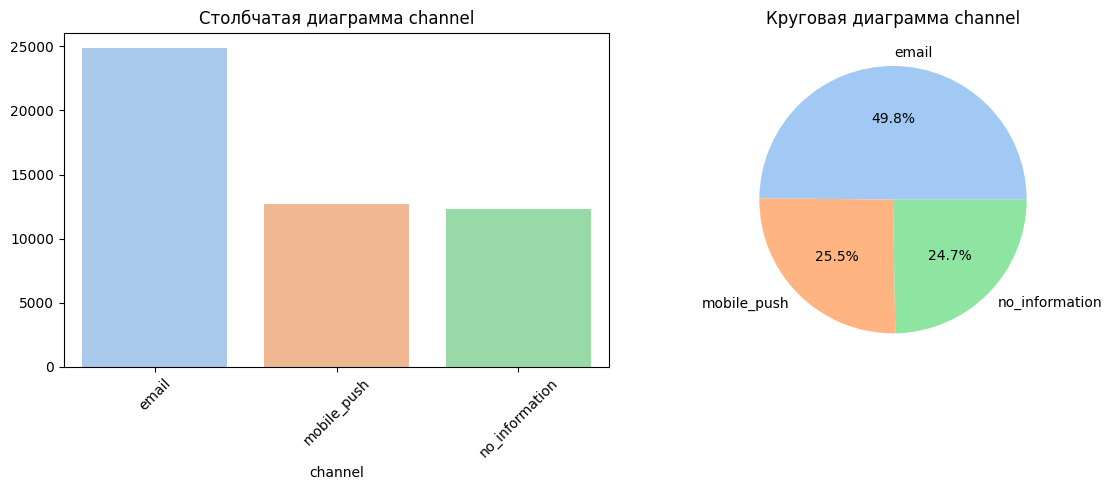

Визуализация признака: total_purchases


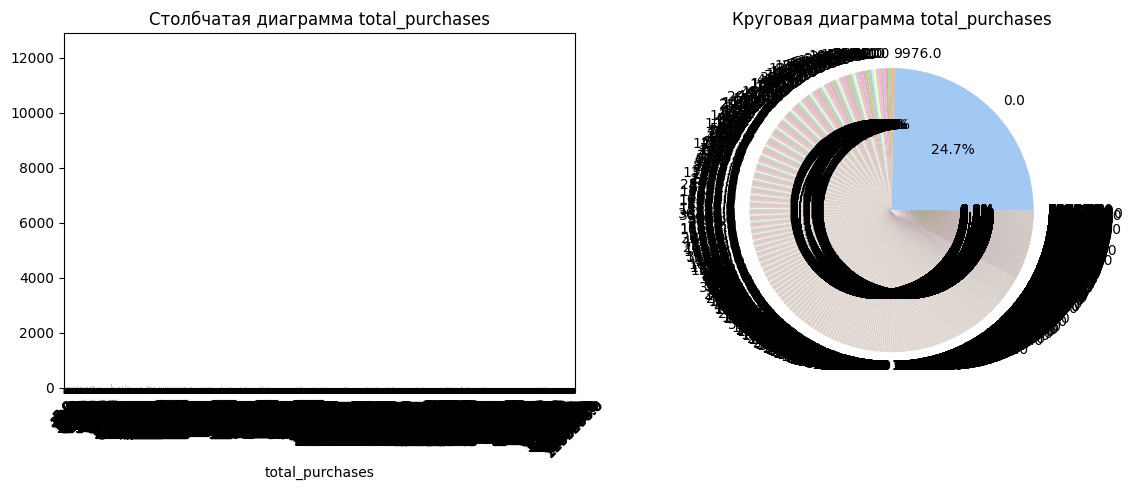

Визуализация признака: has_interaction


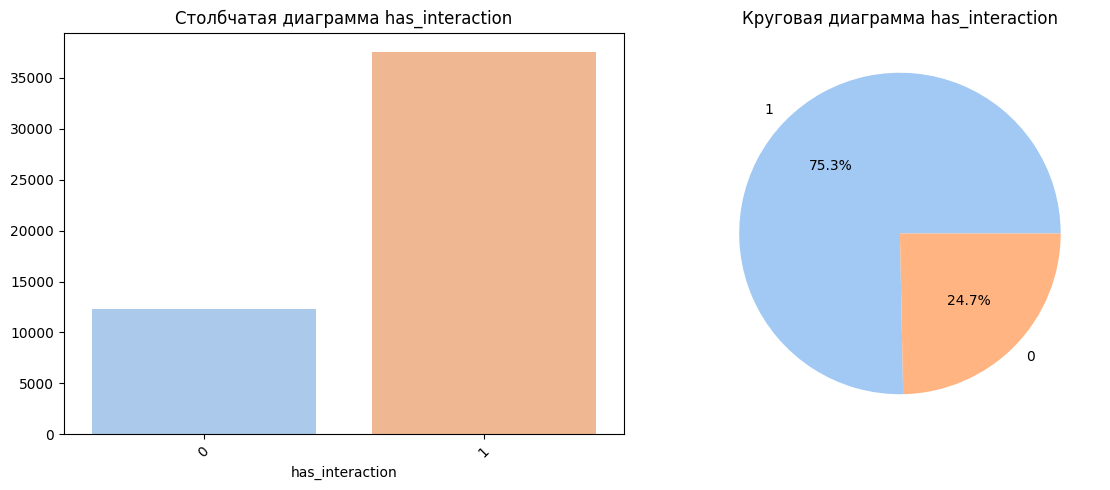

Визуализация признака: target


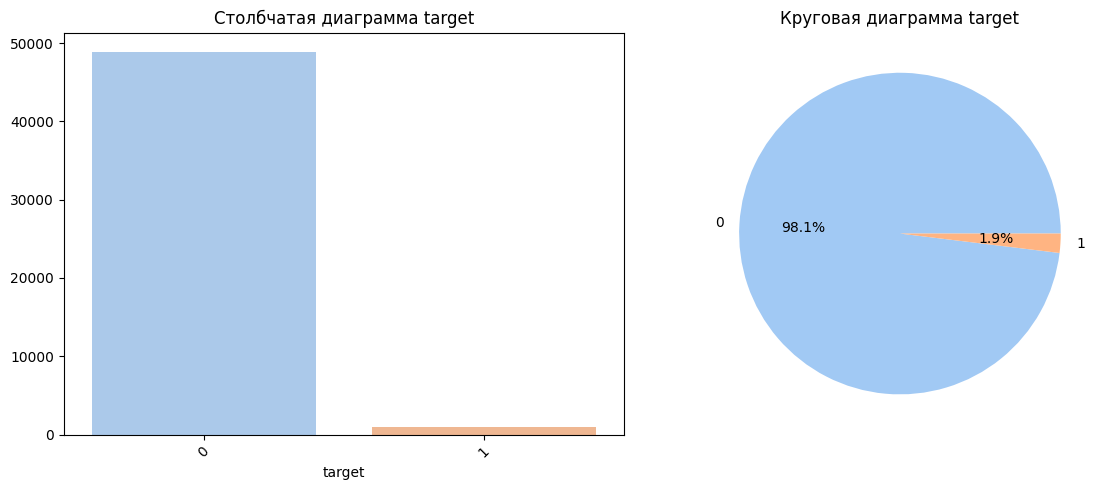

In [118]:
for feature in categorical_cols:
    print(f"Визуализация признака: {feature}")
    plot_categorical_feature(final_data, feature)


In [123]:
final_data['total_purchases'].describe()

count    4.984900e+04
mean     7.388097e+03
std      3.260691e+04
min      0.000000e+00
25%      6.000000e+00
50%      1.276000e+03
75%      5.742000e+03
max      3.293544e+06
Name: total_purchases, dtype: float64

In [125]:
final_data.describe()

,client_id,total_quantity,total_spent,avg_price,max_price,last_purchase_date,has_interaction,total_clicks,total_purchases,total_opens,...,category_emb_42,category_emb_43,category_emb_44,category_emb_45,category_emb_46,category_emb_47,category_emb_48,category_emb_49,days_since_last_purchase,target
count,4.984900e+04,49849.000000,4.984900e+04,49849.000000,49849.000000,49849,49849.000000,4.984900e+04,4.984900e+04,4.984900e+04,...,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000
mean,1.515916e+18,17.420209,2.076241e+04,1483.901398,1792.131377,2023-02-19 01:38:30.329193984,0.753175,4.596852e+05,7.388097e+03,6.921425e+06,...,0.061289,-0.153839,0.074263,0.162644,-0.262084,0.053551,0.058719,-0.035163,361.931593,0.019278
min,1.515916e+18,1.000000,1.000000e+00,1.000000,1.000000,2022-05-16 00:00:00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,-3.041285,-1.962975,-1.194917,-2.089072,-1.405737,-1.911820,-1.767565,-1.866018,0.000000,0.000000
25%,1.515916e+18,4.000000,3.996000e+03,699.000000,910.000000,2022-08-23 00:00:00,1.000000,1.410000e+02,6.000000e+00,3.564000e+03,...,-1.272937,-0.670800,-0.290830,-0.169470,-0.890293,-0.280276,-0.181449,-0.184919,233.000000,0.000000
50%,1.515916e+18,8.000000,9.479000e+03,1249.000000,1499.000000,2023-03-05 00:00:00,1.000000,1.125600e+05,1.276000e+03,1.709144e+06,...,0.762047,0.042906,-0.073260,0.044438,-0.287646,-0.091781,0.140408,-0.017965,348.000000,0.000000
75%,1.515916e+18,18.000000,2.133000e+04,1999.000000,2199.000000,2023-06-28 00:00:00,1.000000,4.077300e+05,5.742000e+03,5.657970e+06,...,1.351260,0.280724,0.305274,0.490572,0.195609,0.371071,0.343743,0.108435,542.000000,0.000000
max,1.515916e+18,7936.000000,5.379582e+06,53499.000000,85499.000000,2024-02-16 00:00:00,1.000000,1.500229e+08,3.293544e+06,1.315290e+09,...,2.920650,2.061280,1.877303,2.516634,1.529045,1.539759,1.700311,1.622001,641.000000,1.000000
std,1.487947e+08,59.207077,5.494490e+04,1388.145378,1647.320646,NaN,0.431169,1.623824e+06,3.260691e+04,2.285714e+07,...,1.539034,0.746857,0.580844,0.516436,0.637247,0.468503,0.700682,0.485490,185.301691,0.137503


**Общее количество наблюдений**
-Всего клиентов: 49 849

total_quantity (Общее количество товаров):

Среднее значение: ~17.42
Минимум: 1
Максимум: 7 936
Стандартное отклонение: ~59.21
Комментарий: Высокое стандартное отклонение и большой максимум указывают на наличие выбросов и скошенное распределение.
total_spent (Общая сумма покупок):

Среднее значение: ~20 762
Минимум: 1
Максимум: ~5.38 млн
Стандартное отклонение: ~54 944.9
Комментарий: Большой разброс в данных, возможное наличие выбросов.
avg_price (Средняя стоимость покупки):

Среднее значение: ~1 483.90
Минимум: 1
Максимум: 53 499
Стандартное отклонение: ~1 388.15
Комментарий: Распределение может быть скошенным вправо.
days_since_last_purchase (Дни с последней покупки):

Среднее значение: ~361.93 дней
Минимум: 0 дней
Максимум: 641 дней
Комментарий: Большинство клиентов совершали покупки примерно год назад.
target (Целевая переменная):

Среднее значение: ~0.0193
Комментарий: Очень низкое среднее значение указывает на сильный дисбаланс классов (только ~1.93% положительных случаев).